在MNIST数据集上训练深度MLP。看看是否可以通过手动调整超参数获得98%以上的精度。

首先尝试搜索最佳学习率（即通过以指数方式增加学习率，根据学习率变化绘制训练损失，并找到损失激增的点）。

接下来，尝试使用Keras Tuner调整超参数——保存检查点，使用早停，并使用TensorBoard绘制学习曲线。

# 一、加载数据
除了sklearn机器学习库中的方法，还可以使用Keras库中读取数据的方法

 tf.keras.datasets.mnist.load_data() 返回的是两个元组且数据类型都是numpy.ndarray，第一个元组是训练集数据，第二个是测试集数据

In [1]:
import numpy as np
import tensorflow as tf

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [2]:
# 检查一下形状 和 分类的标签
print(f"X_train的形状为：{X_train.shape}")
print(f"y_train的形状为：{y_train.shape}")
print(f"X_test的形状为：{X_test.shape}")
print(f"y_test的形状为：{y_test.shape}")
unique_arr, counts_arr = np.unique(y_train, return_counts=True)
print(f"训练集的分类标签为：\n{unique_arr}, \n每个分类的样本数量为：\n{counts_arr}")
unique_arr, counts_arr = np.unique(y_test, return_counts=True)
print(f"测试集的分类标签为：\n{unique_arr}, \n每个分类的样本数量为：\n{counts_arr}")

X_train的形状为：(60000, 28, 28)
y_train的形状为：(60000,)
X_test的形状为：(10000, 28, 28)
y_test的形状为：(10000,)
训练集的分类标签为：
[0 1 2 3 4 5 6 7 8 9], 
每个分类的样本数量为：
[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
测试集的分类标签为：
[0 1 2 3 4 5 6 7 8 9], 
每个分类的样本数量为：
[ 980 1135 1032 1010  982  892  958 1028  974 1009]


<span style="color: red">**注意！！！下面代码只能执行一次，且在分类问题下，只能对X进行缩放**</span>

因为对于颜色值 0-255 来讲，除以一次255就足以把样本的范围缩放到0-1之间了，如果下述代码运行了两次或多次，则会导致样本的尺度极其小，从而导致欠拟合，也许可能永远达不到很高的正确率。所以，对缩放数据要非常注意。或者你可以选择换个变量名，这样不管运行多少次都不会重新缩放数据


In [3]:
X_train, X_test = X_train / 255., X_test / 255.

In [4]:
# 看一下是否缩放到0-1范围内
assert 0 <= np.ptp(X_train) <= 1 and 0 <= np.ptp(X_test) <= 1 , "未缩放到0-1范围内"

# 二、寻找最佳学习率
下面将通过继承Callback类，并在自定义的类中重写相应的方法去搜索最佳学习率，调整学习率的时机选择到每个轮次结束

回调是在训练的不同阶段触发一系列动作的对象（例如 在轮次（epoch）的开始和结束，在批次（batch）的开始和结束）
可以使用回调去：
- 在每个批次训练完成后去记录TensorBoard的日志
- 阶段性的保存模型
- 实现早停机制
- 在训练期间看到模型内部的状态和统计信息
- .etc...

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5796 - accuracy: 0.8496 - val_loss: 0.2981 - val_accuracy: 0.9158
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2191 - accuracy: 0.9356 - val_loss: 0.1363 - val_accuracy: 0.9608
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1365 - accuracy: 0.9576 - val_loss: 0.0903 - val_accuracy: 0.9701
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1218 - accuracy: 0.9622 - val_loss: 0.0879 - val_accuracy: 0.9732
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1153 - accuracy: 0.9653 - val_loss: 0.1043 - val_accuracy: 0.9709
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1148 - accuracy: 0.9663 - val_loss: 0.1676 - val_accuracy: 0.9531
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1267 - accuracy: 0.9649 - val_loss: 0.1915 - val_accuracy:

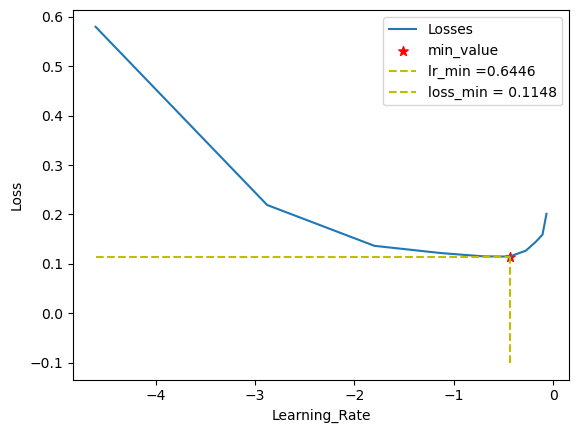

In [5]:
import matplotlib.pyplot as plt
class tun_learning_rate(tf.keras.callbacks.Callback):
    def __init__(self, power):
        super().__init__()
        self.power = power
        self.lr_list = []
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        current_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        self.lr_list.append(current_lr)
        current_lr = current_lr ** (1 / self.power)
        tf.keras.backend.set_value(self.model.optimizer.lr, current_lr)
        self.losses.append(logs['loss'])

    def on_train_end(self, logs=None):
        log_lr = np.log(self.lr_list)
        loss_min = np.min(self.losses)
        min_idx = np.argmin(self.losses)
        lr_min = log_lr[min_idx]
        plt.plot(log_lr, self.losses, label="Losses")
        plt.scatter(lr_min, loss_min, s=50, marker="*", c="r", label="min_value")
        plt.vlines(lr_min, -0.1, loss_min, linestyles="--", colors="y", label=f"lr_min ={self.lr_list[min_idx]:.4f}")
        plt.hlines(loss_min, log_lr[0], lr_min, linestyles="--", colors="y", label=f"loss_min = {loss_min:.4f}")
        plt.legend()
        plt.xlabel("Learning_Rate")
        plt.ylabel("Loss")
        plt.show()


# 模型搭建
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))



optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)

# 模型编译
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics="accuracy"
)


#拟合数据
lr_tuner = tun_learning_rate(1.6)
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[lr_tuner])

# 三、提高模型的准确率
如果图像横轴为学习率（对数化），纵轴为损失值，则最佳学习率的值为函数最小值的 1/10，然后使用最佳的学习率继续去提高模型的性能，例如使用早停机制

下面模型的回调中使用了检查点、早停和TensorBoard机制

1.检查点

  检查点是在训练过程中的特定时刻去**自动保存模型的当前状态**（包括权重、优化器的状态等等），通过实例化 Keras下callbacks包的ModelCheckpoint实现，至少需要传一个路径来指明你要将当前模型的检查点存在磁盘的什么位置

2.早停机制

   如果n轮迭代模型的损失没有变化（一定范围内无变化），则停止迭代。Keras中通过callbacks包下的EarlyStopping来实现，其中，patience参数相当于sklearn中的n_iter_no_change参数

3.TensorBoard

   TensorBoard 是一个内置于 tensorflow中的可视化工具包，可以将深度学习的“黑箱”变得透明化

   - 首先，它通过实例化Keras中callbacks下的TensorBoard类实现对模型拟合时日志的存储，需指定一个日志保存路径

   - 其次，通过命令`tensorboard --logdir=YOU_PATH`去启动可视化服务，默认启动端口号为6006. 注意路径中不能带有中文

   - 最后一点需要注意的是，tensorboard生成日志文件时，文件名中会有你本机的电脑名称，如果有中文的话，也是不能可视化的


In [6]:
# 检查点只保存权重，减少磁盘占用
checkpoint = tf.keras.callbacks.ModelCheckpoint("./models/my_checkpoint.weights.h5",
                                                save_weights_only=True)

earlystop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

tb = tf.keras.callbacks.TensorBoard(log_dir="./log/my_log1")

# 搭模型
new_model = tf.keras.Sequential()
new_model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
new_model.add(tf.keras.layers.Dense(300, activation="relu"))
new_model.add(tf.keras.layers.Dense(100, activation="relu"))
new_model.add(tf.keras.layers.Dense(10, activation="softmax"))

# 编译
new_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.06),
    loss="sparse_categorical_crossentropy",
    metrics="accuracy"
)

new_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[checkpoint, earlystop, tb])

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2965 - accuracy: 0.9147 - val_loss: 0.1438 - val_accuracy: 0.9584
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1283 - accuracy: 0.9617 - val_loss: 0.1037 - val_accuracy: 0.9675
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0886 - accuracy: 0.9735 - val_loss: 0.1070 - val_accuracy: 0.9653
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0655 - accuracy: 0.9805 - val_loss: 0.0740 - val_accuracy: 0.9769
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0509 - accuracy: 0.9849 - val_loss: 0.0746 - val_accuracy: 0.9753
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0410 - accuracy: 0.9877 - val_loss: 0.0678 - val_accuracy: 0.9785
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0325 - accuracy: 0.9907 - val_loss: 0.0717 - val_accuracy:

**可以看到，模型在第8个轮次时，准确率最高，约达到98%，再往后两个轮次，模型显然有点过拟合**

此模型的检查点为 ./models/my_checkpoint.weights.h5

此模型的日志存放在 ./log/my_log1文件夹下，在装有tensorboard的环境下，使用 tensorboard --logdir="./log/my_log1"即可查看